## Importing Libraries

In [1]:
import numpy as np
import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras import backend as K
print(K)

import keras
from keras.preprocessing.image import ImageDataGenerator

print("Keras version %s" %keras.__version__)
import matplotlib.pyplot as plt

<module 'plaidml.keras.backend' from 'E:\\anaconda3\\envs\\plaidML\\lib\\site-packages\\plaidml\\keras\\backend.py'>
Keras version 2.2.4


In [2]:
batch_size = 8
epochs = 50
num_classes=10

In [3]:
import os
from keras.preprocessing.image import ImageDataGenerator

datadir = 'E:\\Xception\\imagenette2'
trainingset = datadir+'\\train\\'
testset = datadir + '\\val\\'

batch_size = 8
data_generator = ImageDataGenerator(
    rescale = 1. / 255)

train_generator = data_generator.flow_from_directory(
    directory=trainingset,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_generator = data_generator.flow_from_directory(
    directory=testset,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
Image input (256, 256, 3)
Classes: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
Loaded 9469 training samples from 10 classes.
Loaded 3925 test samples from 10 classes.


In [12]:
import cv2  # pip install opencv-python
import numpy as np
import os


class ImageLoader:
    """Load images in arrays without batches."""

    def __init__(self, train_dir, test_dir):
        """Create class."""
        self.train_dir = train_dir
        self.test_dir = test_dir

    def load_data(self):
        """Load the data."""
        features, labels = [], []

        for source in [self.train_dir, self.test_dir]:
            input, output = [], []
            print(os.listdir(source))
            for class_name in os.listdir(source):
                if os.path.isdir(class_name):
                    for img_name in os.listdir(class_name):
                        img = cv2.imread(os.path.join(self.train_dir, class_name, img_name))
                        
                        # ...
                        # Modify your image array here.
                        # ...

                        input.append(img)
                        output.append(class_name)  # or other method to convert label
                        print(output)

            # Shuffle labels.
            combine = list(zip(input, output))  # zip as list for Python 3
            np.random.shuffle(combine)
            #input, output = zip(*combine)
            features.append(input)
            labels.append(output)

        return [[np.array(features[0], dtype=np.float32),
                 np.array(labels[0], dtype=np.float32)],
                [np.array(features[1], dtype=np.float32),
                 np.array(labels[1], dtype=np.float32)]]


dataset = ImageLoader('E:\\Xception\\imagenette2\\train', 'E:\\Xception\\imagenette2\\val')
(trainX, trainY), (testX, testY) = dataset.load_data()

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [9]:
trainX

array([], dtype=float32)

## Visualizing Input Images

n02979186


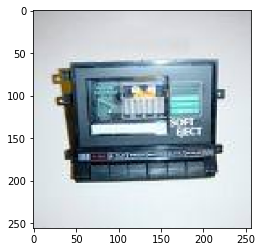

n01440764


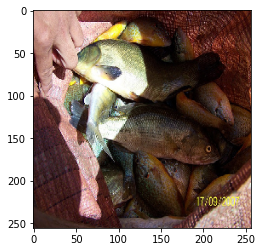

n03000684


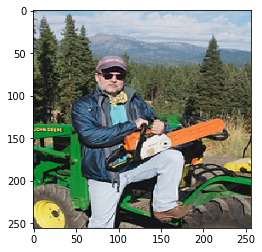

In [4]:
import matplotlib.pyplot as plt

n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()
    

## Model

![picture](https://miro.medium.com/max/1400/1*hOcAEj9QzqgBXcwUzmEvSg.png)

In [5]:
def block(layer,filters,kernel_size,strides=1,padding='valid',layer_name='conv',
          pool_size=2,pool_strides=None,filter_2=False):
          
  if layer_name == 'conv':
    layer = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,
                                   strides=strides,use_bias=False)(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.ReLU()(layer)
    layer = keras.layers.Conv2D(filters=filters*2,kernel_size=kernel_size,
                                  use_bias=False)(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.ReLU()(layer)
  
  elif layer_name == 'separable_conv':
    layer = keras.layers.SeparableConv2D(filters, kernel_size,
                                            padding=padding, use_bias=False)(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.ReLU()(layer)    
    if filter_2:
      layer = keras.layers.SeparableConv2D(filter_2, kernel_size,
                                              padding=padding, use_bias=False)(layer)
    else:
      layer = keras.layers.SeparableConv2D(filters, kernel_size,
                                              padding=padding, use_bias=False)(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.MaxPooling2D(pool_size, strides=pool_strides,
                                         padding=padding)(layer)
  return layer

def add_block(layer,filters,kernel_size,strides=1,padding='valid',pool_size=2,pool_strides=None):
  layer = keras.layers.ReLU()(layer)
  layer = keras.layers.SeparableConv2D(filters,kernel_size,padding=padding,use_bias=False)(layer)
  layer = keras.layers.BatchNormalization()(layer)
  layer = keras.layers.ReLU()(layer)
  layer = keras.layers.SeparableConv2D(filters,kernel_size,padding=padding,use_bias=False)(layer)
  layer = keras.layers.BatchNormalization()(layer)
  layer = keras.layers.MaxPooling2D(pool_size, strides=pool_strides,
                                         padding=padding)(layer)
  return layer  

In [6]:
def entry_flow(input_layer):	
  block_1 = block(input_layer,32,3,2,layer_name='conv')

  block_2 = block(block_1,128,3,padding='same',layer_name='separable_conv')
  layer_add = keras.layers.Conv2D(filters=128,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(block_1)
  layer_add = keras.layers.BatchNormalization()(layer_add)
  layer = keras.layers.Add()([block_2,layer_add])

  block_3 = add_block(layer,256,3,1,'same',3,2)
  layer_add = keras.layers.Conv2D(filters=256,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(layer)
  layer_add = keras.layers.BatchNormalization()(layer_add)
  layer = keras.layers.Add()([block_3,layer_add])

  block_4 = add_block(layer,728,3,1,'same',3,2)
  layer_add = keras.layers.Conv2D(filters=728,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(layer)
  layer_add = keras.layers.BatchNormalization()(layer_add)
  layer = keras.layers.Add()([block_4,layer_add])
  return layer

In [7]:
def middle_flow(input_layer):
    for _ in range(8):
      for __ in range(3):
        layer = keras.layers.ReLU()(input_layer)
        layer = keras.layers.SeparableConv2D(filters=728, kernel_size=3,
                                                padding='same',use_bias=False)(layer)
        layer = keras.layers.BatchNormalization()(layer)
      output_layer = keras.layers.Add()([input_layer, layer])
    return output_layer

In [8]:
def exit_flow(input_layer):
  layer = keras.layers.ReLU()(input_layer)
  block_1 = block(layer,728,3,padding='same',layer_name='separable_conv',
                  pool_size=3,pool_strides=2,filter_2=1024)
 
  layer_add = keras.layers.Conv2D(filters=1024, kernel_size=1, 
                                 strides=2, padding='same', use_bias=False)(input_layer)
  layer_add = keras.layers.BatchNormalization()(layer_add)                                  
  layer = keras.layers.Add()([block_1, layer_add])

  layer = keras.layers.SeparableConv2D(filters=1536, kernel_size=3,
                                          padding='same',use_bias=False)(layer)
  layer = keras.layers.BatchNormalization()(layer)
  layer = keras.layers.ReLU()(layer)
  layer = keras.layers.SeparableConv2D(filters=2048, kernel_size=3,
                                          padding='same',use_bias=False)(layer)
  layer = keras.layers.BatchNormalization()(layer)
  layer = keras.layers.ReLU()(layer)

  layer = keras.layers.GlobalAvgPool2D()(layer)
  layer = keras.layers.Dense(1000, activation='relu')(layer)
 
  return layer


In [9]:
def xception(shape,include_top):
  model_input = keras.layers.Input(shape=shape)
  entry_block = entry_flow(model_input)
  mid_block = middle_flow(entry_block)
  exit_block = exit_flow(mid_block)

  if include_top:
    model_output = keras.layers.Dense(10)(exit_block)
    model = keras.models.Model(model_input, model_output)
  model = keras.models.Model(model_input, model_output)
  model.summary()
  return model

shape =  input_shape
#shape =  image_w,image_h,3
model = xception(shape,include_top=True)

INFO:plaidml:Opening device "opencl_amd_gfx1010.0"


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [29]:
starter_learning_rate = 1e-2
end_learning_rate = 1e-5
decay_steps = 80000
#learning_rate_fn = keras.optimizers.schedules.PolynomialDecay(
#    starter_learning_rate,
#    decay_steps,
#    end_learning_rate,
#    power=0.8)

def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = keras.callbacks.LearningRateScheduler(step_decay)


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False), 
              #optimizer = keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])


callbacks = [
    keras.callbacks.ModelCheckpoint('xception_model.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       monitor='loss')]

model.fit_generator(train_generator,
          epochs=epochs,steps_per_epoch=train_generator.n//train_generator.batch_size,
          validation_data=test_generator, validation_steps=test_generator.n//test_generator.batch_size+1)


#model.fit(train_dataset,
#          epochs=epochs,steps_per_epoch=len(train_images)//batch_size,
#          callbacks=callbacks)


Epoch 1/50


INFO:plaidml:Analyzing Ops: 818 of 1853 operations complete


 230/1183 [====>.........................] - ETA: 11:33 - loss: 16.1181 - acc: 0.1114

INFO:plaidml:Analyzing Ops: 742 of 1853 operations complete


 411/1183 [=========>....................] - ETA: 10:06 - loss: 16.1181 - acc: 0.1089

KeyboardInterrupt: 

## Inference

In [ ]:
plt.figure(figsize=(15,15))
for i in range(8):
  for val in val_dataset.take(1):
    plt.subplot(4,2,i+1)
    img  = (val[0][i]*255.0)
    plt.imshow(tf.cast(img,tf.uint8))
    y_pred = model.predict(np.expand_dims(val[0][i],axis=0))
    y_pred = np.argmax(y_pred,axis=1)
    plt.title('Ground Truth{}, Predicted{}'.format(val[1][i],y_pred))
    plt.subplots_adjust(wspace=1, hspace=1)
plt.show()